In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.colors import ListedColormap


In [2]:
#load data

def load_data(name):
    df = pd.read_csv(name + '.csv')
    df.dob=pd.to_datetime(df.dob)
    
    return df

fifa_20 = load_data('./players_20')
fifa_20.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,potential,value_eur,wage_eur,player_positions,preferred_foot,international_reputation,weak_foot,skill_moves,work_rate,body_type,real_face,release_clause_eur,player_tags,team_position,team_jersey_number,loaned_from,joined,contract_valid_until,nation_position,nation_jersey_number,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,gk_kicking,...,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,94,95500000,565000,"RW, CF, ST",Left,5,4,4,Medium/Low,Messi,Yes,195800000.0,"#Dribbler, #Distance Shooter, #Crosser, #FK Sp...",RW,10.0,NaN,2004-07-01,2021.0,NaN,NaN,87.0,92.0,92.0,96.0,39.0,66.0,NaN,NaN,NaN,...,48,40,94,94,75,96,33,37,26,6,11,15,14,8,89+2,89+2,89+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,93+2,92+2,87+2,87+2,87+2,92+2,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,93,58500000,405000,"ST, LW",Right,5,4,5,High/Low,C. Ronaldo,Yes,96500000.0,"#Speedster, #Dribbler, #Distance Shooter, #Acr...",LW,7.0,NaN,2018-07-10,2022.0,LS,7.0,90.0,93.0,82.0,89.0,35.0,78.0,NaN,NaN,NaN,...,63,29,95,82,85,95,28,32,24,7,11,15,14,11,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,92,105500000,290000,"LW, CAM",Right,5,5,5,High/Medium,Neymar,Yes,195200000.0,"#Speedster, #Dribbler, #Playmaker , #Crosser,...",CAM,10.0,NaN,2017-08-03,2022.0,LW,10.0,91.0,85.0,87.0,95.0,32.0,58.0,NaN,NaN,NaN,...,51,36,87,90,90,94,27,26,29,9,9,15,15,11,84+3,84+3,84+3,90+3,89+3,89+3,89+3,90+3,90+3,90+3,90+3,89+3,82+3,82+3,82+3,89+3,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,93,77500000,125000,GK,Right,3,3,1,Medium/Medium,Normal,Yes,164700000.0,NaN,GK,13.0,NaN,2014-07-16,2023.0,GK,1.0,NaN,NaN,NaN,NaN,NaN,NaN,87.0,92.0,78.0,...,34,19,11,65,11,68,27,12,18,87,92,78,90,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,91,90000000,470000,"LW, CF",Right,4,4,4,High/Medium,Normal,Yes,184500000.0,"#Speedster, #Dribbler, #Acrobat",LW,7.0,NaN,2019-07-01,2024.0,LF,10.0,91.0,83.0,86.0,94.0,35.0,66.0,NaN,NaN,NaN,...,54,41,87,89,88,91,34,27,22,11,12,6,8,8,83+3,83+3,83+3,89+3,88+3,88+3,88+3,89+3,89+3,89+3,89+3,89+3,83+3,83+3,83+3,89+3,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [5]:
# create player main position
def create_main_position(data):
        data.loc[:, 'main_position'] = data['player_positions'].apply(lambda x: x.split(',')[0])
        data.head()
#create_main_position(fifa_20)


In [8]:
create_main_position(fifa_20)


Iteration  0 : Average Score: 0.736 Best so far: 0.66 ['A. Oxlade-Chamberlain']
Iteration  5 : Average Score: 0.632 Best so far: 0.55 ['T. Partey']
Iteration  10 : Average Score: 0.545 Best so far: 0.5 ['Thiago']
Iteration  15 : Average Score: 0.521 Best so far: 0.5 ['Thiago']
Iteration  20 : Average Score: 0.496 Best so far: 0.4 ['Arthur']
Iteration  25 : Average Score: 0.453 Best so far: 0.4 ['Arthur']
Iteration  30 : Average Score: 0.4 Best so far: 0.4 ['Arthur']
Iteration  35 : Average Score: 0.4 Best so far: 0.4 ['Arthur']
Iteration  40 : Average Score: 0.399 Best so far: 0.37 ['M. Pjanić']
Iteration  45 : Average Score: 0.393 Best so far: 0.37 ['M. Pjanić']


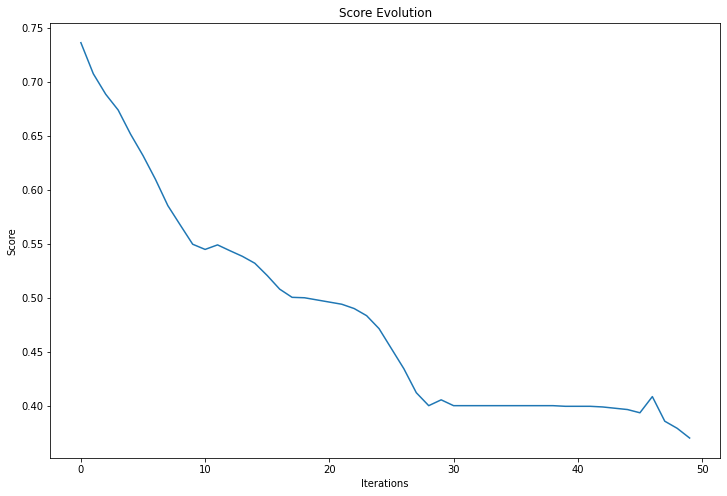

Best players for ['CM']:
M. Pjanić:
	Age: 29, Overall: 86

Max Budget:  50000000
Budget Used:  42500000


In [20]:
## select the random sample for the given posistion from the total population 

def init_population(data, n, positions_target):

    population = []
    for _ in range(n):
        indv = []
        for j in positions_target:
            p = data[data['main_position'] == j].sample(1)
            indv.append(p.iloc[0].short_name)
        population.append(indv)

    return population
    



#One point Crossover
def crossover(indv_1, indv_2):

    if random.random() < prob_crossover:

        pos = random.randint(0,len(indv_1))
        f1 = indv_1[:pos] + indv_2[pos:]
        f2 = indv_2[:pos] + indv_1[pos:]
        return [f1, f2]

    else:
        return [indv_1,indv_2]


def random_mutation(indv, positions, data):
    new_indv = indv.copy()

    for i in range(len(indv)):
        if  random.random() < prob_mutation:
            p = data[data['main_position'] == positions[i]].sample(1)

            new_indv[i] = p.iloc[0]['short_name']

    return new_indv


def evaluate_population(original_data, population, budget):
    alpha = 0.5 #coefficient for budget
    beta = 0  #coefficient for age
    gamma = 0  #coefficient for defenders
    theta = 0.2 #coefficient for midfielder
    omega = 0.3 #coefficient for striker
    
    max_values = [budget, 35, 95, 95, 96] ## budget, age , team_player
    
    scores = []
    for indv in population:

        accumulated_value = []
        ages = []
        marking_skill = []
        player_vision = []
        finishing_skill = []
        team_players = []   ##calculates how many players exist for the same posistion
        for i in indv:
            p = original_data[original_data['short_name'] == i].iloc[0]
            
            accumulated_value.append(1.2 * p.value_eur)
            ages.append(p.age)
            marking_skill.append(p.defending_marking)
            player_vision.append(p.mentality_vision)
            finishing_skill.append(p.attacking_finishing)
            team_players.append(len(original_data[(original_data['club'] == test_team) & (original_data['main_position'] == p.main_position)]))
                
        scores.append(round(alpha * (np.abs(budget - np.sum(accumulated_value))/max_values[0])
                            + beta * (np.median(ages)/max_values[1]) 
                            + gamma * (np.max(marking_skill)/ max_values[2])
                            + theta * (np.max(player_vision)/ max_values[3])
                            + omega * (np.max(finishing_skill)/ max_values[4]),2))
         #                   + gamma * (np.mean(team_players)/max_values[2])
         #                   + theta * (10550000-np.min(accumulated_value)/max_values[3]), 2))

    return scores

def indv_value(indv, data):

    accumulated_value = 0
    for i in indv:
        p = data[data['short_name'] == i]
        accumulated_value += p.iloc[0].value_eur
        
    return accumulated_value

def argsort_list(seq):
    return [x for x,y in sorted(enumerate(seq), key = lambda x: x[1])]


def elitism(original_data, population, offspring, budget):
    
    scores_pop = evaluate_population(original_data, population, budget)
    scores_offs = evaluate_population(original_data, offspring, budget)
    
    comp_elite = int(len(population) * elitism_size)
    
    population = [population[ind] for ind in argsort_list(scores_pop)]
    offspring = [offspring[ind] for ind in argsort_list(scores_offs)]
    
    new_population = population[:comp_elite] + offspring[:len(population) - comp_elite]

    return new_population


def evolve(data, target_positions, budget):

    num_iters = 50

    scores = np.zeros(num_iters)
    best_indv = None
    best_score = float('+inf')

    population = init_population(data, n_pop, target_positions)

    #print("Initial Population: ", population)
    
    for it in range(num_iters):

        pool = population
        
        #Crossover
        parents = []
        for i in  range(0, n_pop - 1, 2):
            indiv_1= pool[i]
            indiv_2 = pool[i+1]
            parents.extend(crossover(indiv_1, indiv_2)) 
        
        #Mutation
        offspring = []
        for indv in parents:
            offspring.append(random_mutation(indv, target_positions, data))
        
        #Select the best inviduals: Elitism
        population = elitism(fifa_20, population, offspring, budget)
        pop_scores = evaluate_population(data, population, budget)
                
        for i in range(len(pop_scores)):

            if pop_scores[i] < best_score:
                best_indv = pop_scores[i]
                best_players = population[i]
                best_score = pop_scores[i]

        scores[it] = np.mean(pop_scores)

        if it % 5 == 0:
            print("Iteration ", it, ": Average Score:", round(scores[it], 3), "Best so far:", round(best_score, 3), best_players)

        
    plt.figure(figsize=(12, 8))
    plt.plot(scores)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.title('Score Evolution')
    plt.show()
    
    print('Best players for {}:'.format(target_positions))

    for i in best_players:
        p = data[data['short_name'] == i]
        print('{}:\n\tAge: {}, Overall: {}'.format(i, p.iloc[0].age, p.iloc[0].overall))
            
    print('\nMax Budget: ', budget)
    print('Budget Used: ', indv_value(best_players, data))


# CONFIGURATION PARAMETERS

target_pos = ['CM']
b = 50000000
n_pop = 50
prob_mutation = 0.5
prob_crossover = 0.5
elitism_size = 0.6
test_team = 'Liverpool'
evolve(fifa_20, target_pos, b)